<img src="../figures/header.jpg" style="display:block; margin:auto; width:55%; height:210px;">

<br><br> 

<p style="text-align:center; background-color: darkgray; color: lightyellow; border-radius:10px; line-height:1.4; font-size:32px; font-weight:bold; padding: 9px;">
            <strong>Dog Breed Image Classification</strong>
</p>  
  
<p style="text-align:center; color: Black; border-radius:10px; font-family:helvetica; line-height:1.0; font-size:28px; font-weight:normal; text-transform: capitalize; padding: 5px;">
    End-to-end Deep Learning Project for
    <br>Dog Breed Multi-Class Image Classification:
    <br>EDA, Transfer Learning, Fine-Tuning, and Model Deployment
</p>    

# 1. Introduction

## 1.1 Background

In recent years, the canine population has witnessed a surge in the number of mixed-breed dogs. While the charm of mixed-breed dogs lies in their one-of-a-kind characteristics, the increasing variety poses challenges when it comes to identifying their specific breeds. This is where a classification model proves to be invaluable.

Creating a classification model for identifying breeds of dogs can serve various purposes including:
- Lost and found services to help efficiently reunite lost dogs with owners.
- Educational tools through interactive websites or mobile applications to learn about different breeds.
- Pet adoption platforms to identify breeds within shelters, enhancing adoptiong and rehoming processes.
- Dog shows and competitions to assist judges in verifying participating dog breeds.

In the accompanying [modeling_notebook](modeling_notebook), our study explores the multi-class [stanford dogs image dataset](https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset), then uses transfer learning to train and fine-tune four modern neural network architectures. We'll use built-in [Keras applications](https://keras.io/api/applications) to use architectures with pre-trained ImageNet weights for the following models: 
- [xception](https://arxiv.org/abs/1610.02357)
- [InceptionResNetV2](https://arxiv.org/abs/1602.07261)
- [EfficientNetB3](https://arxiv.org/abs/1905.11946)
- [ConvNeXtSmall](https://arxiv.org/abs/2201.03545)

In this notebook, we show:
- **Serverless Deployment**: Save the best model with tensorflow lite, create a docker image for the environment with minimized dependencies, and deploy it to the cloud using AWS Lambda
- **Kubernetes Deployment**: Convert the model to tensorflow format, set up a flask application, build docker images for them, and deploy the full application to AWS EKS. 
- **Front-end Application**: Create a low-code front-end for our application using streamlit and connect it to the cloud-deployed AWS services.

The full framework for that you will complete through both notebooks for this project is shown below:

<img src="../figures/dog-prediction-framework.png" width="700">


## 1.2 Table of Contents.

### 1. Introduction
- 1.1 - Description of the project methodology and real world use-case.
- 1.2 - Table of contents **(We Are Here)**
- 1.3 - Import statements for all dependencies. This section **must** be run before executing the rest of the project.
### 2. Serverless Deployment
   - 2.1 - Save trained EfficientNetB3V2 model to tflite
   - 2.2 - Local deployment with Docker
   - 2.3 - Cloud deployment with AWS Lambda
### 3. Kubernetes Deployment
   - 3.1 - Save trained EfficientNetB3V2 model to tensorflow
   - 3.2 - Local deployment with Docker and Kind
   - 3.3 - Cloud deployment with AWS Elastic Kubernetes Service (EKS)
### 4. Application Deployment
   - 4.1 - Application deployment with streamlit

## 1.3 Import Statements

Ensure that your python version and package versions match the following notebook output before proceeding, as some versions of python, scikit-learn and tensorflow are incompatible with the project.

In [7]:
# model saving
import tensorflow as tf
from tensorflow import keras
import os
import tensorflow.lite as tflite
from tensorflow.keras.preprocessing.image import load_img

# model analysis
import numpy as np
import matplotlib.pyplot as plt

# cluster deployment
import grpc
from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2_grpc

# sending requests to deployed models
import requests
import base64
from io import BytesIO
from PIL import Image
from urllib import request
from argparse import ArgumentParser

In [8]:
import session_info
session_info.show(html=False)

-----
PIL                 10.2.0
grpc                1.42.0
keras               2.10.0
matplotlib          3.8.2
numpy               1.26.4
requests            2.31.0
session_info        1.0.0
tensorflow          2.10.1
tensorflow_serving  NA
-----
IPython             8.21.0
jupyter_client      8.6.0
jupyter_core        5.7.1
jupyterlab          4.1.0
-----
Python 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.19045-SP0
-----
Session information updated at 2024-02-20 21:04


# 2. Serverless Deployment

The following helper functions post a sample image to the local and cloud deployed functions

In [9]:
def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img

In [10]:
def test(test_type="lambda"):
    if test_type == "local":
        post_url = 'http://localhost:8080/2015-03-31/functions/function/invocations'
    elif test_type == "lambda":
        post_url = "https://4bfnidjam6.execute-api.us-east-1.amazonaws.com/deploy-1/predict"
    else:
        return Null
    
    image_url = "https://upload.wikimedia.org/wikipedia/commons/4/4b/Golden_retriever_running_on_a_dirt_road.jpg"
    
    img = download_image(image_url)
    
    img = img.resize((299, 299), Image.NEAREST)
    bytes=img.tobytes()
    decoded_image = base64.b64encode(bytes).decode("utf8")

    data = {'image': decoded_image, 'size': img.size}
    result = requests.post(post_url, json=data).json()

    print(result)

## 2.1 Save model to tf-lite

### Save model to tflite

In [11]:
path = os.path.join('..', 'models', 'effnetV2B3_model.keras')
effnetB3_model = keras.models.load_model(path)

In [12]:
converter = tf.lite.TFLiteConverter.from_keras_model(effnetB3_model)

tflite_model = converter.convert()
outpath = os.path.join('..', 'models', 'model.tflite')

with open(outpath, 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\lenni\AppData\Local\Temp\tmprolcjhj3\assets


INFO:tensorflow:Assets written to: C:\Users\lenni\AppData\Local\Temp\tmprolcjhj3\assets


### Test tflite model

In [18]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

image_url = "https://upload.wikimedia.org/wikipedia/commons/4/4b/Golden_retriever_running_on_a_dirt_road.jpg"
img = download_image(image_url)
img = img.resize((299, 299), Image.NEAREST)
X = preprocess_input(np.array([img], dtype='float32'))

In [19]:
X.shape

(1, 299, 299, 3)

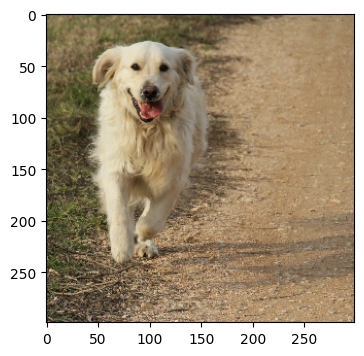

In [20]:
fig, axs = plt.subplots(1,1, figsize=(4,4))
axs.imshow(img)

In [21]:
# load tflite model
interpreter = tflite.Interpreter(model_path=outpath)
interpreter.allocate_tensors()

In [22]:
interpreter.get_input_details()

[{'name': 'serving_default_input_60:0',
  'index': 0,
  'shape': array([  1, 299, 299,   3]),
  'shape_signature': array([ -1, 299, 299,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [23]:
interpreter.get_output_details()

[{'name': 'StatefulPartitionedCall:0',
  'index': 788,
  'shape': array([  1, 120]),
  'shape_signature': array([ -1, 120]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [24]:
# index for inputs and outputs
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

# compute predictions with model
interpreter.set_tensor(input_index, X)
interpreter.invoke()
preds = interpreter.get_tensor(output_index)

Looking at the predictions for both the original model and tflite, we can see they both predict the correct image, chihuahua. The prediction values themselves are slightly different for each class, but are within range (< 0.2% difference) to move forward.

In [46]:
classes = ['Chihuahua', 'Japanese spaniel', 'Maltese dog', 'Pekinese', 'Shih tzu', 'Blenheim spaniel', 'Papillon', 'Toy terrier', 'Rhodesian ridgeback', 'Afghan hound', 'Basset', 'Beagle', 'Bloodhound', 'Bluetick', 'Black and tan coonhound', 'Walker hound', 'English foxhound', 'Redbone', 'Borzoi', 'Irish wolfhound', 'Italian greyhound', 'Whippet', 'Ibizan hound', 'Norwegian elkhound', 'Otterhound', 'Saluki', 'Scottish deerhound', 'Weimaraner', 'Staffordshire bullterrier', 'American staffordshire terrier', 'Bedlington terrier', 'Border terrier', 'Kerry blue terrier', 'Irish terrier', 'Norfolk terrier', 'Norwich terrier', 'Yorkshire terrier', 'Wire haired fox terrier', 'Lakeland terrier', 'Sealyham terrier', 'Airedale', 'Cairn', 'Australian terrier', 'Dandie dinmont', 'Boston bull', 'Miniature schnauzer', 'Giant schnauzer', 'Standard schnauzer', 'Scotch terrier', 'Tibetan terrier', 'Silky terrier', 'Soft coated wheaten terrier', 'West highland white terrier', 'Lhasa', 'Flat coated retriever', 'Curly coated retriever', 'Golden retriever', 'Labrador retriever', 'Chesapeake bay retriever', 'German short haired pointer', 'Vizsla', 'English setter', 'Irish setter', 'Gordon setter', 'Brittany spaniel', 'Clumber', 'English springer', 'Welsh springer spaniel', 'Cocker spaniel', 'Sussex spaniel', 'Irish water spaniel', 'Kuvasz', 'Schipperke', 'Groenendael', 'Malinois', 'Briard', 'Kelpie', 'Komondor', 'Old english sheepdog', 'Shetland sheepdog', 'Collie', 'Border collie', 'Bouvier des flandres', 'Rottweiler', 'German shepherd', 'Doberman', 'Miniature pinscher', 'Greater swiss mountain dog', 'Bernese mountain dog', 'Appenzeller', 'Entlebucher', 'Boxer', 'Bull mastiff', 'Tibetan mastiff', 'French bulldog', 'Great dane', 'Saint bernard', 'Eskimo dog', 'Malamute', 'Siberian husky', 'Affenpinscher', 'Basenji', 'Pug', 'Leonberg', 'Newfoundland', 'Great pyrenees', 'Samoyed', 'Pomeranian', 'Chow', 'Keeshond', 'Brabancon griffon', 'Pembroke', 'Cardigan', 'Toy poodle', 'Miniature poodle', 'Standard poodle', 'Mexican hairless', 'Dingo', 'Dhole', 'African hunting dog']
dict_predictions = dict(zip(classes, preds[0]))
keras_preds = sorted(dict_predictions.items(), key=lambda x:x[1], reverse=True)[:5]
keras_preds

[('Golden retriever', 6.056432),
 ('Great pyrenees', 2.281072),
 ('Kuvasz', 1.2518035),
 ('Labrador retriever', 0.11739846),
 ('Flat coated retriever', -1.8855036)]

In [47]:
dict_predictions = dict(zip(classes, effnetB3_model.predict(X)[0]))
tf_preds = sorted(dict_predictions.items(), key=lambda x:x[1], reverse=True)[:5]
tf_preds

1/1 [==============================] - 0s 26ms/step


[('Golden retriever', 6.054596),
 ('Great pyrenees', 2.285763),
 ('Kuvasz', 1.2559241),
 ('Labrador retriever', 0.117991425),
 ('Flat coated retriever', -1.8886685)]

In [48]:
keras_preds = np.array(keras_preds)[:,1].astype(float)
tf_preds = np.array(tf_preds)[:,1].astype(float)

In [49]:
rpd = np.mean(np.abs(keras_preds - tf_preds) / ((keras_preds + tf_preds)/2) * 100)
rpd

0.18009818610758693

## 2.2 Local Deployment

To deploy locally, navigate up to the root folder and run the following from a terminal or command prompt. Please note that docker must already be installed on your local machine. See the [official documentation](https://docs.docker.com/engine/install/) for Docker Engine installation.

- Build the container: `docker build -t dog-prediction -f deployment/lambda.dockerfile .`
- Run the container: `docker run -it --rm -p 8080:8080 dog-prediction:latest`

This will build an image from the [lambda dockerfile](../deployment/lambda.dockerfile) using python 3.10, tflite and [lambda_function.py](../pythonlambda_function.py). Once the container is running, you should be able to execute the following commands to recieve a prediction from a web-hosted image. The code is exported to [test.py](../pythontest.py) and can be run from the python folder with the command `python test.py`.

In [50]:
test("local")

[['Golden retriever', 6.056431770324707], ['Great pyrenees', 2.281071901321411], ['Kuvasz', 1.2518035173416138], ['Labrador retriever', 0.1173984631896019], ['Flat coated retriever', -1.8855036497116089]]


It should return the above response with the top 5 dog breeds ascending order, each followed by the corresponding model score.

The following runs [test.py](../python/test.py) which contains similar code, and can be run from the command line.

In [51]:
%run -i ../python/test.py -t local

[['Golden retriever', 6.056431770324707], ['Great pyrenees', 2.281071901321411], ['Kuvasz', 1.2518035173416138], ['Labrador retriever', 0.1173984631896019], ['Flat coated retriever', -1.8855036497116089]]


## 2.3 AWS Lambda Deployment

### Push Docker Images

AWS Lambda is a serverless deployment method for simple applications. We're going to set everything up from our command line using the python awscli package. First, we need to get access keys for logging into the account.

- From the IAM page, click Access Management -> Users -> Create User
    - Give the user the following permission: AmazonEC2ContainerRegistryFullAccess
- Create access key: From the IAM page, click 'Users' then the user you just created. Click Create Access Key -> Command Line Interface (CLI) -> Next
    - Copy down the access key and secret access key for the next step

Next, login to the account from the command line. Run the following and include the access keys you just copied down. Leave the default region, which will later be called {REGION} and output format.

> aws configure

Create the repository and copy the number at the beginning of the 'repositoryUri' that it returns, which will later be called {AWS_ACCOUNT_ID}.

> aws ecr create-repository --repository-name dog-prediction-images

Login

> aws ecr get-login-password --region {REGION} | docker login --username AWS --password-stdin {AWS_ACCOUNT_ID}.dkr.ecr.{REGION}.amazonaws.com

Tag and push the local docker image to the repository you just created

> docker tag dog-prediction:latest 730335336972.dkr.ecr.us-east-2.amazonaws.com/dog-prediction-images:dog-model-001
> 
> docker push 730335336972.dkr.ecr.us-east-2.amazonaws.com/dog-prediction-images:dog-model-001


### Lambda Deployment

**Create a Lambda Function**
- Open AWS Lambda → Create function → Container image → Add a function name → Add the image we just created using ‘Browse images’ → Create function

**Test lambda function**
- Set timeout from 3→30 and click the test button. Make sure it passes before moving on.

**Create API Gateway**
- Go to [API Gateway](https://us-east-2.console.aws.amazon.com/apigateway/main) page
- If you already have an API, click ‘Create API’. Whether or not you do, click ‘Build’ under REST API.
- Assign it a name

**Create resource**
- Click ‘create resource’
- Give it the name ‘predict’ then click ‘create’

**Create method**
- With ‘predict’ method highlighted, click ‘create method’
- method type = POST
- Leave ‘lambda function’
- Add the function you just create as the lambda function
- Create ‘create method’

**Create test**
- Click “test”
- In the request body, add the json

    `{"url": "https://upload.wikimedia.org/wikipedia/commons/8/8b/Redbone-coonhound-detail.jpg"}`
- Click ‘test’ and make sure it gives the correct response ‘redbone’

**Deploy**
- Click ‘Deploy API’
- Give it a ‘new stage’
- Give it a name
- click ‘deploy’


### Test Lambda Function

The model is deployed to an AWS Lambda function hosted by a docker image on AWS EC2. The following now posts to the AWS cloud model instead.

In [52]:
test("lambda")

[['Golden retriever', 6.056431770324707], ['Great pyrenees', 2.281071901321411], ['Kuvasz', 1.2518035173416138], ['Labrador retriever', 0.1173984631896019], ['Flat coated retriever', -1.8855036497116089]]


The following runs [test.py](test.py) with the cloud deployed Lambda function, and can be run from the command line.

In [53]:
%run -i ../python/test.py -t lambda

[['Golden retriever', 6.056431770324707], ['Great pyrenees', 2.281071901321411], ['Kuvasz', 1.2518035173416138], ['Labrador retriever', 0.1173984631896019], ['Flat coated retriever', -1.8855036497116089]]


# 3. Kubernetes Deployment

To test our kubernetes deployment before deploying it to the cloud, we'll set up a multi-container environment with docker-compose. Here are some helper functions we'll use for loading, sending and converting the image to the proper format.

In [54]:
def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img

In [55]:
def batch_image(img):
    if img.mode != 'RGB':
        img = img.convert('RGB')
        
    img = img.resize((299, 299), Image.NEAREST)    
    X = np.array(img, dtype='float32')
    batch = np.expand_dims(X, axis=0)

    return batch

In [56]:
def np_to_protobuf(data):
    return tf.make_tensor_proto(data, shape=data.shape)

## 3.1 Save model to tensorflow format

Save keras model to tensorflow format

Use saved_model_cli to check for info we'll need to use later when serving the model
- **Signature definition**: 'serving_default'
- **Input**: 'input_35'
- **Output**: 'dense_65'

In [57]:
path = os.path.join('..', 'models', 'effnetV2B3_model.keras')
effnetB3_model = keras.models.load_model(path)
tf.saved_model.save(effnetB3_model, os.path.join('..', 'models', 'converted_model'))

INFO:tensorflow:Assets written to: ..\models\converted_model\assets


INFO:tensorflow:Assets written to: ..\models\converted_model\assets


In [58]:
!saved_model_cli show --dir ../models/converted_model --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_60'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 299, 299, 3)
        name: serving_default_input_60:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_113'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 120)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Concrete Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          inputs: Te

## 3.2 Local Deployment with Docker and Kind

### Model container from command line/terminal

First we can run a simple container for serving our model from the command line or terminal. First **navigate** to the models folder. See below for a range of commands for different OS's

Windows powershell:

> docker run -it --rm -p 8500:8500 -v "$(pwd)/converted_model:/models/converted_model/1" -e MODEL_NAME="converted_model" tensorflow/serving:2.7.0

Windows command line:

> docker run -it --rm ^
    -p 8500:8500 ^
    -v "%cd%/converted_model:/models/converted_model/1" ^
    -e MODEL_NAME="converted_model" ^
    tensorflow/serving:2.7.0

Mac silicon:

> docker run -it --rm -p 8500:8500 -v "$(pwd)/converted_model:/models/converted_model/1" -e MODEL_NAME="converted_model" tensorflow/serving:2.7.0

Next we need to test that our model is served correctly. We'll use gRPC to start up a communication channel at the port that the model is locally hosted on (8500), then send our input data to that channel to recieve the results.
- tf-serving makes use of gRPC, a framework for connecting services in and across datacenters
- gRPC uses *Protocol Buffers* (AKA ***Protobuf***) for formatting data, a kind of binary encoding which is faster and more efficient than JSON.
- gRPC can establish both insecure and secure communication channels. Secure channels can make use of authentication and other advanced security features, but since our model server won't be accessible from the outside, insecure channels are adequate for our use case.
- The *stub* is our interface with the tf-serving inorder to make inference with our model. It needs a channel as a parameter to establish the communication.

In [59]:
host = 'localhost:8500'
channel = grpc.insecure_channel(host)
stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)

The following blocks download an image and convert it into a numpy array for sending to the model

In [60]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/4/4b/Golden_retriever_running_on_a_dirt_road.jpg"
img = download_image(image_url)
X = batch_image(img)

Set up our request to our model by: 
- Instancing a Protobuf request object and defining its model name, the model's signature name (input_35) that we saw before and its input.
- Convert the numpy array of our image to Protobuf format and copy it to the request object.

Inference is done with the stub's Predict() method. Returns a protobuf response object that access our predictions with the name of the aoutput that we found in the signature definition (dense_65).

In [64]:
pb_request = predict_pb2.PredictRequest()
pb_request.model_spec.name = 'converted_model'
pb_request.model_spec.signature_name = 'serving_default'
pb_request.inputs['input_60'].CopyFrom(np_to_protobuf(X))

In [65]:
pb_response = stub.Predict(pb_request, timeout=20.0)
preds = pb_response.outputs['dense_113'].float_val

In [66]:
classes = ['Chihuahua', 'Japanese spaniel', 'Maltese dog', 'Pekinese', 'Shih tzu', 'Blenheim spaniel', 'Papillon', 'Toy terrier', 'Rhodesian ridgeback', 'Afghan hound', 'Basset', 'Beagle', 'Bloodhound', 'Bluetick', 'Black and tan coonhound', 'Walker hound', 'English foxhound', 'Redbone', 'Borzoi', 'Irish wolfhound', 'Italian greyhound', 'Whippet', 'Ibizan hound', 'Norwegian elkhound', 'Otterhound', 'Saluki', 'Scottish deerhound', 'Weimaraner', 'Staffordshire bullterrier', 'American staffordshire terrier', 'Bedlington terrier', 'Border terrier', 'Kerry blue terrier', 'Irish terrier', 'Norfolk terrier', 'Norwich terrier', 'Yorkshire terrier', 'Wire haired fox terrier', 'Lakeland terrier', 'Sealyham terrier', 'Airedale', 'Cairn', 'Australian terrier', 'Dandie dinmont', 'Boston bull', 'Miniature schnauzer', 'Giant schnauzer', 'Standard schnauzer', 'Scotch terrier', 'Tibetan terrier', 'Silky terrier', 'Soft coated wheaten terrier', 'West highland white terrier', 'Lhasa', 'Flat coated retriever', 'Curly coated retriever', 'Golden retriever', 'Labrador retriever', 'Chesapeake bay retriever', 'German short haired pointer', 'Vizsla', 'English setter', 'Irish setter', 'Gordon setter', 'Brittany spaniel', 'Clumber', 'English springer', 'Welsh springer spaniel', 'Cocker spaniel', 'Sussex spaniel', 'Irish water spaniel', 'Kuvasz', 'Schipperke', 'Groenendael', 'Malinois', 'Briard', 'Kelpie', 'Komondor', 'Old english sheepdog', 'Shetland sheepdog', 'Collie', 'Border collie', 'Bouvier des flandres', 'Rottweiler', 'German shepherd', 'Doberman', 'Miniature pinscher', 'Greater swiss mountain dog', 'Bernese mountain dog', 'Appenzeller', 'Entlebucher', 'Boxer', 'Bull mastiff', 'Tibetan mastiff', 'French bulldog', 'Great dane', 'Saint bernard', 'Eskimo dog', 'Malamute', 'Siberian husky', 'Affenpinscher', 'Basenji', 'Pug', 'Leonberg', 'Newfoundland', 'Great pyrenees', 'Samoyed', 'Pomeranian', 'Chow', 'Keeshond', 'Brabancon griffon', 'Pembroke', 'Cardigan', 'Toy poodle', 'Miniature poodle', 'Standard poodle', 'Mexican hairless', 'Dingo', 'Dhole', 'African hunting dog']
dict_predictions = dict(zip(classes, preds))
top_5 = sorted(dict_predictions.items(), key=lambda x:x[1], reverse=True)[:5]
top_5

[('Golden retriever', 6.056427955627441),
 ('Great pyrenees', 2.281074285507202),
 ('Kuvasz', 1.2518045902252197),
 ('Labrador retriever', 0.1173974946141243),
 ('Flat coated retriever', -1.8855047225952148)]

### Model serving container from Dockerfile

- Create a simple dockerfile with tf-serving. It's saved to [image-model.dockerfile](../deployment/model/image-model.dockerfile).
  - Points to the [converted_model](../models/converted_model) directory
- Build the container
- Run at port 8500

**DOCKERFILE**

> FROM tensorflow/serving:2.7.0
> 
> COPY models/converted_model models/converted_model/1
> 
> ENV MODEL_NAME="converted_model"

**BUILD**
> docker build -t dog-prediction-model:v1 -f deployment/model/image-model.dockerfile .

**RUN**
> docker run -it --rm -p 8500:8500 dog-prediction-model:v1

Test it again

In [68]:
!python ../python/test.py -t model

[('Golden retriever', 6.056427955627441), ('Great pyrenees', 2.281074285507202), ('Kuvasz', 1.2518045902252197), ('Labrador retriever', 0.1173974946141243), ('Flat coated retriever', -1.8855047225952148)]


### Gateway container from Dockerfile

- Create a dockerfile for the gateway with flask front-end. It's saved to the kubernetes folder as [image-gateway.dockerfile](../deployment/gateway/image-gateway.dockerfile).
  - Builds the environment with [Pipfile](../deployment/gateway/Pipfile) and [Pipfile.lock](../deployment/gateway/Pipfile.lock)
  - Uses the python files [gateway.py](../python/gateway.py) and [proto.py](../python/proto.py) for prediction
- Build the container
- Run at port 9696

**DOCKERFILE**
> FROM python:3.8.12-slim
> 
> RUN pip install pipenv
> 
> WORKDIR /app
> 
> COPY ["Pipfile", "Pipfile.lock", "./"]
> 
> RUN pipenv install --system --deploy
> 
> COPY ["gateway.py", "proto.py". "./"]
> 
> EXPOSE 9696
> 
> ENTRYPOINT ["gunicorn", "--bind=0.0.0.0:9696", "gateway:app"]

**BUILD**

> docker build -t dog-prediction-gateway:v1 -f deployment/gateway/image-gateway.dockerfile .

**RUN**

> docker run -it --rm -p 9696:9696 dog-prediction-gateway:v1



The following will currently fail with grpc_status 14, meaning that the gateway at port 9696 cannot locate and connect to the serving model at port 8500. We solve this using docker compose to connect the two ports within one multi-container network.

In [69]:
url = 'http://localhost:9696/predict'

img = download_image(image_url)

img = img.resize((299, 299), Image.NEAREST)
bytes=img.tobytes()
decoded_image = base64.b64encode(bytes).decode("utf8")

data = {'image': decoded_image, 'size': (299, 299)}
result = requests.post(url, json=data)
print(result)

<Response [500]>


### Multi-container network with Docker Compose

To connect the gateway (port 9696) to the serving model (port 8500), **navigate to the deployment folder** and start a virtual network using docker-compose. The following is saved to [docker-compose.yaml](../deployment/docker-compose.yaml).

**DOCKERFILE**

>version: "3.9" <br>
>services: <br>
>&emsp; dog-model: <br>
>&emsp; &emsp; image: dog-prediction-model:v1 <br>
>&emsp; gateway: <br>
>&emsp; &emsp; image: dog-prediction-gateway:v1 <br>
>&emsp; &emsp; environment: <br>
>&emsp; &emsp; &emsp; - TF_SERVING_HOST=dog-model:8500 <br>
>&emsp; &emsp; ports: <br>
>&emsp; &emsp; &emsp; - "9696:9696" <br>

**RUN**
> docker-compose up

**SHUT DOWN**
> docker-compose down

Now while the multi-container network is running, the following blocks will ping the gateway, which will then ping the model to return the predictions.

In [70]:
url = 'http://localhost:9696/predict'

img = download_image(image_url)

img = img.resize((299, 299), Image.NEAREST)
bytes=img.tobytes()
decoded_image = base64.b64encode(bytes).decode("utf8")

data = {'image': decoded_image, 'size': (299, 299)}
result = requests.post(url, json=data).json()
print(result)

[['Golden retriever', 6.056427955627441], ['Great pyrenees', 2.281074285507202], ['Kuvasz', 1.2518045902252197], ['Labrador retriever', 0.1173974946141243], ['Flat coated retriever', -1.8855047225952148]]


In [72]:
!python ../python/test.py -t gateway

[['Golden retriever', 6.056427955627441], ['Great pyrenees', 2.281074285507202], ['Kuvasz', 1.2518045902252197], ['Labrador retriever', 0.1173974946141243], ['Flat coated retriever', -1.8855047225952148]]


### Local kubernetes cluster (kind + kubectl)

1. Install kubectl, the kubernetes command line tool. **Note** that Docker Desktop for both Windows and MacOS already includes kubectl. Installation instructions for all major platforms are available in the [official Kubernetes website](https://kubernetes.io/docs/tasks/tools/).
2. Install kind, which lets you create local kubernetes clusters with Docker. Installation instructions are available on the [official website](https://kind.sigs.k8s.io/docs/user/quick-start/).

**Model Pod**

> docker build -t dog-prediction-model:v1 -f deployment/model/image-model.dockerfile .
>
> kind create cluster
>
> kind load docker-image dog-prediction-model:v1
>
> kubectl apply -f deployment/model/model-deployment.yaml
>
> kubectl get pod
>
> kubectl port-forward {name from get pod} 8500:8500

In [ ]:
!kubectl get pod
# next you would run kubectl port-forward dog-prediction-model-76d94b8cdd-5jp2m 8500:8500

NAME                                    READY   STATUS    RESTARTS   AGE
dog-prediction-model-76d94b8cdd-5jp2m   1/1     Running   0          53m


In [75]:
!python ../python/test.py -t model

[('Golden retriever', 6.056427955627441), ('Great pyrenees', 2.281074285507202), ('Kuvasz', 1.2518045902252197), ('Labrador retriever', 0.1173974946141243), ('Flat coated retriever', -1.8855047225952148)]


**Model Service**

> kubectl apply -f deployment/model/model-service.yaml
>
> kubectl port-forward service/dog-prediction-model 8500:8500  

In [77]:
!python ../python/test.py -t model

[('Golden retriever', 6.056427955627441), ('Great pyrenees', 2.281074285507202), ('Kuvasz', 1.2518045902252197), ('Labrador retriever', 0.1173974946141243), ('Flat coated retriever', -1.8855047225952148)]


**Deployment Pod**

> docker build -t dog-prediction-gateway:v1 -f deployment/gateway/image-gateway.dockerfile .
>
> kind load docker-image dog-prediction-gateway:v1
>
> kubectl apply -f deployment/gateway/gateway-deployment.yaml
>
> kubectl get pod
>
> kubectl port-forward {name from get pod} 9696:9696

**Test Deployment**


> kubectl exec -it {name from get pod} -- bash
> 
> apt update
>
> apt install telnet
>
> telnet dog-prediction-model.default.svc.cluster.local 8500
> 
> exit

In [79]:
!python ../python/test.py -t gateway

[['Golden retriever', 6.056427955627441], ['Great pyrenees', 2.281074285507202], ['Kuvasz', 1.2518045902252197], ['Labrador retriever', 0.1173974946141243], ['Flat coated retriever', -1.8855047225952148]]


**Gateway Service**

> kubectl apply -f deployment/gateway/gateway-service.yaml 
> 
> kubectl port-forward service/dog-prediction-gateway 8080:80

In [80]:
!python ../python/test.py -t kube

[['Golden retriever', 6.056427955627441], ['Great pyrenees', 2.281074285507202], ['Kuvasz', 1.2518045902252197], ['Labrador retriever', 0.1173974946141243], ['Flat coated retriever', -1.8855047225952148]]


## 3.3 Cloud Deployment with EKS

### Determine cluster size

Before deploying to EKS, let's check how many resources (CPU and memory) we'll need. Run the following block to scroll down to the allocated resources section. We can see that our limits include 500m CPU, which is half of a CPU unit, and 1518Mi memory which is around 1.6GB.

In [81]:
!kubectl describe nodes

Name:               kind-control-plane
Roles:              control-plane
Labels:             beta.kubernetes.io/arch=amd64
                    beta.kubernetes.io/os=linux
                    kubernetes.io/arch=amd64
                    kubernetes.io/hostname=kind-control-plane
                    kubernetes.io/os=linux
                    node-role.kubernetes.io/control-plane=
                    node.kubernetes.io/exclude-from-external-load-balancers=
Annotations:        kubeadm.alpha.kubernetes.io/cri-socket: unix:///run/containerd/containerd.sock
                    node.alpha.kubernetes.io/ttl: 0
                    volumes.kubernetes.io/controller-managed-attach-detach: true
CreationTimestamp:  Tue, 20 Feb 2024 21:23:32 -0500
Taints:             <none>
Unschedulable:      false
Lease:
  HolderIdentity:  kind-control-plane
  AcquireTime:     <unset>
  RenewTime:       Tue, 20 Feb 2024 21:27:21 -0500
Conditions:
  Type             Status  LastHeartbeatTime                 LastTransi

Our EKS cluster will be hosted on an EC2 instance. The on-demand pricing for different instances can be found here: [https://aws.amazon.com/ec2/pricing/on-demand/](https://aws.amazon.com/ec2/pricing/on-demand/). For this project, we don't expect a high amount of traffic, so given our limits, a t3.small instance should be sufficient. It provides 2 CPU units, with 2GB of memory. The full cost breakdown for running one cluster is shown below:

In [82]:
# 0.0208/hr * 24hr/day * 30days/month
monthly_ec2_price = 0.0208*24*30
monthly_cluster_price = 0.10*24*30
monthly_price = monthly_ec2_price + monthly_cluster_price
monthly_price

86.97600000000001

### Create cluster

The config file for setting up the clusters is [eks-config.yaml](../deployment/eks-config.yaml). Change the region to the same region used in section 5.2 for your ECR repository. Ensure that you are logged into an user account with sufficient permissions for deploying a cluster, then run the following command. If it fails due to insufficient priviledges, try giving the user admin access with AWS IAM and attempt to re-run.

> eksctl create cluster -f deployment/eks-config.yaml

If there are any issues during cluster creation, open CloudFormation in the AWS console and delete the stack created by this cluster. Use the same {REGION} as in eks-config.yaml.

> eksctl delete cluster --name=dog-prediction-eks --disable-nodegroup-eviction

### Push docker images

If logged out, login to your account via the command line with the following

> aws ecr get-login-password --region {REGION} | docker login --username AWS --password-stdin {AWS_ACCOUNT_ID}.dkr.ecr.{REGION}.amazonaws.com

Tag and push your local docker images to the AWS ECR registry we previously created, dog-prediction-images

> docker tag dog-prediction-gateway:v1 {AWS_ACCOUNT_ID}.dkr.ecr.{REGION}.amazonaws.com/dog-prediction-images:dog-prediction-gateway
>
> docker tag dog-prediction-model:v1 {AWS_ACCOUNT_ID}.dkr.ecr.{REGION}.amazonaws.com/dog-prediction-images:dog-prediction-model
>
> docker push {AWS_ACCOUNT_ID}.dkr.ecr.{REGION}.amazonaws.com/dog-prediction-images:dog-prediction-model
> 
> docker push {AWS_ACCOUNT_ID}.dkr.ecr.{REGION}.amazonaws.com/dog-prediction-images:dog-prediction-gateway

### Create pods and services

Update the image on line 17 in gateway-deployment.yaml and model-deployment.yaml from:
- `dog-prediction-model:v1` to `{AWS_ACCOUNT_ID}.dkr.ecr.{REGION}.amazonaws.com/dog-prediction-images:dog-prediction-model`
- `dog-prediction-gateway:v1` to `{AWS_ACCOUNT_ID}.dkr.ecr.{REGION}.amazonaws.com/dog-prediction-images:dog-prediction-gateway`

Then set up the pods and services on the cloud using:

> kubectl apply -f deployment/model/model-deployment.yaml
> 
> kubectl apply -f deployment/model/model-service.yaml
> 
> kubectl get pod # check if the pod is active
> 
> kubectl get service # check if service is working

Then set up port-forwarding and test that the pod in EKS is running properly

> kubectl port-forward service/dog-prediction-model 8500:8500


The model is also deployed to an interactive application hosted by Streamlit. The code for the application is shown below, and is saved to [streamlit_app](../python/streamlit_app.py). The general logic is as follows:
- `st.file_uploader` downloads the image via user input
- `url` records the link to the cloud deployed model. This is currently set to a productionized lambda function.
- `st.button` sends the image to the cloud deployment model for inference
- `st.markdown` prints the predictions returned by the model

Run ``streamlit run python/streamlit_app.py`` to test it locally, or go to [https://dog-prediction.streamlit.app/](https://dog-prediction.streamlit.app/) to test the deployed application.

In [83]:
!python ../python/test.py -t model

[('Golden retriever', 6.056429862976074), ('Great pyrenees', 2.2810726165771484), ('Kuvasz', 1.2518024444580078), ('Labrador retriever', 0.11739922314882278), ('Flat coated retriever', -1.8855029344558716)]



> kubectl apply -f deployment/gateway/gateway-deployment.yaml
> 
> kubectl apply -f deployment/gateway/gateway-service.yaml
> 
> kubectl get service

Copy the EXTERNAL-IP from the dog-prediction-gateway service to the URL below to test it

In [90]:
url = 'http://ac842723604204b1d8b94efb760d38a7-1664883915.us-east-1.elb.amazonaws.com/predict'
img = img.resize((299, 299), Image.NEAREST)
bytes=img.tobytes()
decoded_image = base64.b64encode(bytes).decode("utf8")

data = {'image': decoded_image, 'size': (299, 299)}
result = requests.post(url, json=data).json()
result

[['Golden retriever', 6.056429862976074],
 ['Great pyrenees', 2.2810726165771484],
 ['Kuvasz', 1.2518024444580078],
 ['Labrador retriever', 0.11739922314882278],
 ['Flat coated retriever', -1.8855029344558716]]

In [88]:
!python ../python/test.py -t eks

[['Golden retriever', 6.056429862976074], ['Great pyrenees', 2.2810726165771484], ['Kuvasz', 1.2518024444580078], ['Labrador retriever', 0.11739922314882278], ['Flat coated retriever', -1.8855029344558716]]


### Delete cluster

To ensure that the eks cluster doesn't rack up significant costs, delete it after testing.

> eksctl delete cluster --name=dog-prediction-eks --disable-nodegroup-eviction

# 4. Streamlit Application

The model is also deployed to an interactive application hosted by Streamlit. The code for the application is shown below, and is saved to [streamlit_app](../python/streamlit_app.py). The general logic is as follows:
- `st.file_uploader` downloads the image via user input
- `url` records the link to the cloud deployed model. This is currently set to a productionized lambda function.
- `st.button` sends the image to the cloud deployment model for inference
- `st.markdown` prints the predictions returned by the model

Run ``streamlit run python/streamlit_app.py`` to test it locally, or go to [https://dog-prediction.streamlit.app/](https://dog-prediction.streamlit.app/) to test the deployed application.

In [ ]:
def main():
    st.title("Dog Breed Classification")
    image_file = st.file_uploader(
        "Upload Image for classification", type=["jpg", "jpeg", "heic"]
    )

    url = "https://4bfnidjam6.execute-api.us-east-1.amazonaws.com/deploy-1/predict"
    #url = 'http://ac842723604204b1d8b94efb760d38a7-1664883915.us-east-1.elb.amazonaws.com/predict'

    if image_file is not None:
        with st.spinner("Processing image..."):
          img = Image.open(image_file)
        st.image(img)
        #st.text("Processing image...")
    
        if st.button("Predict"):
            img = decode_image(img)
            data = {'image': img, 'size': (299, 299)}

            with st.spinner("Predicting..."):
                result = requests.post(url, json=data).json()
            
            st.markdown("Match found! :balloon: \n\n **Top 5 dog breeds matched with your image:**")
            
            table = ["Rank | Breed | Score",  "--- | --- | ---"]
            for i in range(len(result)):
                table.append(f"{i+1} | {result[i][0]} | {result[i][1]:.5f}")
            st.markdown("\n".join(table))

To use the application:

- Click 'Browse files' to upload an image.
- Click 'Predict' to post to the cloud.
- While the image is being processed, you should see a status wheel.
- Once it has completed, the application will output a table with the top 5 dog breeds and model scores.

See below for an example:

<img src="../figures/app.PNG">